In [1]:
import os 
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np 
import tensorflow as tf
import tensorflow as tf 
from tensorflow.keras.layers import (Input, 
                                     GlobalAveragePooling2D, 
                                     Dense, 
                                     BatchNormalization, 
#                                      InstanceNormalization
                                    )

from tensorflow.keras.applications.efficientnet import EfficientNetB0 as EfficientNet

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
TRAIN_PATH = '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train'
IMAGE_SHAPE = [100, 100, 3]
NUM_CLASSES = 65
BATCH_SIZE = 512

# Load Data 

In [3]:
def load_filepaths_labels(folder_path):
    file_paths = []
    labels = []

    # List all directories (labels) in the given folder
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)

        # Check if the item in the directory is a subdirectory
        if os.path.isdir(label_path):
            # List all files in the subdirectory
            files = os.listdir(label_path)
            
            # Create file paths and corresponding labels
            file_paths.extend([os.path.join(label_path, file) for file in files])
            labels.extend([int(label)] * len(files))

    return file_paths, labels

In [4]:
fileps, labels = load_filepaths_labels(TRAIN_PATH)
fileps.pop(13107), labels.pop(13107)

('/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train/32/user009_lam_end_010.png',
 32)

# Preprocess Data

In [5]:
def min_max(tensor, t):
    # Find the indices where the values are greater than t
        
    indices = tf.where(tensor > t)
#         print(indices)
    # Find the minimum and maximum indices
    min_ = indices[0][0]
    max_ = indices[-1][0]
    return min_, max_

def cut_image(image):
    # Get the dimensions of the image
    
    t = 0.3
    pos_image = tf.where(image < 0, -1 * image, image)
    pos_image = tf.where(pos_image < t, 0.0, pos_image)            
    
    x_min, x_max = min_max(tf.reduce_sum(pos_image, axis=0), 1)
    y_min, y_max = min_max(tf.reduce_sum(pos_image, axis=1), 1)
    # Find the first and last values greater than 0.1 along the x-axis

    # Crop the image using the computed indices
    pos_image = pos_image[y_min:y_max, :, :]
    pos_image = pos_image[:, x_min:x_max, :]

    return pos_image, (x_min, x_max)
    
def normalize_image(image):
    # Assuming 'image' is a TensorFlow tensor
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    
    # Normalize the image to the range [0, 1]
    normalized_image = (image - min_val) / (max_val - min_val)

    return normalized_image

def _1(image): 
    return 1- image
    
def load_decode_image(filepath, label, cut_image_ = False):
    # One-hot encoding the label
    label = tf.one_hot(label, depth=NUM_CLASSES)
    label = tf.reshape(label, (65, 1))

    # Read and decode the image
    image = tf.io.read_file(filepath)
    image = tf.image.decode_image(image, channels=1)
        
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = normalize_image(image)
    image = _1(image)
    
    if cut_image_: 
        image, x_minmax = cut_image(image)
    image = tf.image.resize_with_pad(image, target_height=IMAGE_SHAPE[0], target_width=IMAGE_SHAPE[1])

    image = tf.image.grayscale_to_rgb(image)
    return image, label

def build_dataset(filepaths, labels, batch_size = 8, cut_image_ = False, shuffle = True, prefetch = True): 
    
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    
    dataset = dataset.map(lambda x, y: load_decode_image(x, y, cut_image_ = cut_image_))
    dataset = dataset.batch(batch_size)
    
    if shuffle: 
        dataset = dataset.shuffle(3)
        
    if prefetch: 
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
    return dataset 

In [6]:
dataset_with_cut = build_dataset(fileps, labels, batch_size = 512, cut_image_ = True, shuffle = False)
dataset_without_cut = build_dataset(fileps, labels, batch_size = 512, shuffle=False)

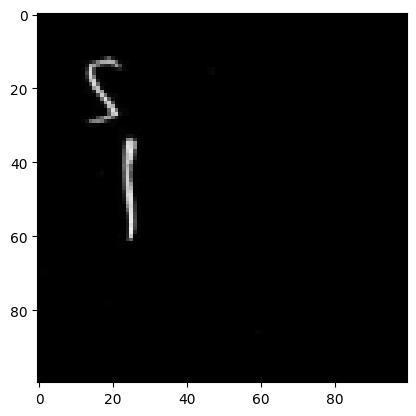

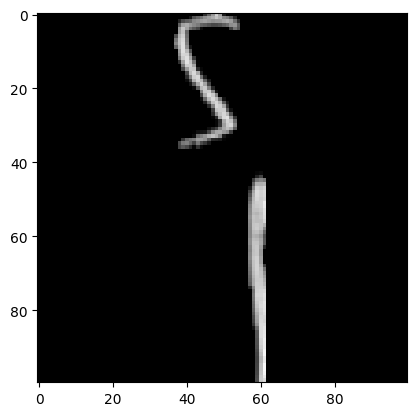

In [7]:
image = next(iter(dataset_with_cut))[0][10]
image_ = next(iter(dataset_without_cut))[0][10]

plt.imshow(image_.numpy())
plt.show()

plt.imshow(image.numpy())
plt.show()

In [8]:
# clear memory
del dataset_with_cut, dataset_without_cut
# build finnal dataset 
dataset = build_dataset(fileps, labels, batch_size = 64, cut_image_ = True)

# Define Model

In [9]:
enet = EfficientNet(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SHAPE,
    classifier_activation='softmax'
)
enet.trainable = False

def build_model(input_shape, n_labels): 
    inputs = Input(shape = input_shape)
    
    x = enet(inputs)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(n_labels, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)
    
model = build_model(IMAGE_SHAPE, NUM_CLASSES)
model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 65)                83265     
                                                                 
Total params: 4132836 (15.77 MB)
Trainable params: 83265 (325.25 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

In [10]:
model.compile(optimizer =tf.keras.optimizers.AdamW(lr=1e-5) , 
              loss = 'binary_crossentropy')

# Train Model

In [11]:
model.fit(dataset, epochs = 50)

Epoch 1/50


2023-12-17 13:37:06.270655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


665/665 [==============================] - 72s 90ms/step - loss: 0.0972
Epoch 2/50
665/665 [==============================] - 21s 32ms/step - loss: 0.0992
Epoch 3/50
665/665 [==============================] - 21s 31ms/step - loss: 0.1003
Epoch 4/50
665/665 [==============================] - 21s 32ms/step - loss: 0.1012
Epoch 5/50
665/665 [==============================] - 21s 31ms/step - loss: 0.1016
Epoch 6/50
665/665 [==============================] - 20s 30ms/step - loss: 0.1027
Epoch 7/50
665/665 [==============================] - 21s 32ms/step - loss: 0.1026
Epoch 8/50
665/665 [==============================] - 21s 31ms/step - loss: 0.1012
Epoch 9/50
665/665 [==============================] - 20s 30ms/step - loss: 0.1017
Epoch 10/50
665/665 [==============================] - 21s 31ms/step - loss: 0.1014
Epoch 11/50
665/665 [==============================] - 20s 31ms/step - loss: 0.1018
Epoch 12/50
665/665 [==============================] - 20s 30ms/step - loss: 0.1023
Epoch 13/50


In [12]:
model.save('')